In [1]:
%reload_ext autoreload
%autoreload 2

##### Define ChEMBL and Papyrus versions

In [2]:
chembl_version = '31'
papyrus_version = '05.5'
papyrus_flavor = 'nostereo'

##### Define annotation round

In [3]:
annotation_round = 2

##### Define protein for analysis

In [4]:
analysis_accession = 'P00533' #EGFR
# analysis_accession = 'Q72547' #HIV
# analysis_accession = 'P00519' #ABL1
# analysis_accession = 'O60885' #BRD4
# analysis_accession = 'O75874' #IDH1

##### Define Butina cutoff for clustering

In [5]:
butina_cutoff = {'P00533':0.7, #EGFR
                 'Q72547':0.5, #HIV
                 'P00519':0.5, #ABL1
                 'O60885':0.7, #BRD4
                 'O75874':0.7 #IDH1
                }

##### Define output directory

In [6]:
from mutants_in_pcm import data_path
data_path.data_dir = '../data'

In [7]:
from utils import get_mutant_analysis_path, get_distance_path
data_dir = '1_mutant_statistics'
common_analysis_dir = get_mutant_analysis_path(data_dir, 'common', annotation_round)
bioactivity_analysis_dir = get_mutant_analysis_path(data_dir, 'bioactivity', annotation_round)
compound_analysis_dir = get_mutant_analysis_path(data_dir, 'compound', annotation_round)
distance_dir = get_distance_path(data_dir)

##### Import analysis functions

In [8]:
import os
import re
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import papyrus_scripts

In [9]:
from mutants_in_pcm.preprocessing import merge_chembl_papyrus_mutants
from mutants_in_pcm.mutant_analysis_accession import filter_accession_data
from mutants_in_pcm.mutant_analysis_common_subsets import read_common_subset
from mutants_in_pcm.mutant_analysis_protein import calculate_average_residue_distance_to_ligand
from mutants_in_pcm.mutant_analysis_compounds import butina_cluster_compounds,visualize_molecular_subset_highlights
from mutants_in_pcm.mutant_analysis_clustermaps import (extract_unique_connectivity, pivot_bioactivity_data,
                                                        plot_bioactivity_heatmap,
                                                        plot_bioactivity_clustermap,extract_oldest_year)
from mutants_in_pcm.mutant_analysis_type import read_mutation_distance_Epstein

##### Read mutant bioactivity data and common subset (in this case, All)

In [10]:
# Read annotated bioactivity data for the accession of interest
annotated_data = merge_chembl_papyrus_mutants(chembl_version, papyrus_version, papyrus_flavor,1_000_000, annotation_round)
accession_data = filter_accession_data(annotated_data,analysis_accession)
accession_data

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol
67983,P00533_A750P,AAKJLRGGTJKAMG,9.282,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,CHEMBL553,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
67984,P00533_A750P,BCFGMOOMADDAQU,8.659,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,CHEMBL554,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
67985,P00533_A750P,BIIVYFLTOXDAOV,5.639,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc...,CHEMBL428690,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
67986,P00533_A750P,BMGQWWVMWDBQGC,6.209,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,CHEMBL608533,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
67987,P00533_A750P,BTIHMVBBUGXLCJ,5.000,"Series([], dtype: object)",Papyrus05.5_Christmann2016,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1,Christmann2016.compound.46,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81579,P00533_WT,ZZXUNAFAKNKXFW,5.800,"Series([], dtype: object)",ChEMBL31;Papyrus05.5_Sharma2016;Christmann2016,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,CHEMBL1472492,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,NaN,EGFR_HUMAN,Homo sapiens (Human),EGFR
81580,P00533_WT,ZZYKWZOXZDVUNU,8.149,"Series([], dtype: object)",Papyrus05.5_Sharma2016,CC#CC(=NOCCNCCNC(C)=O)c1cc2c(cc1)ncnc2Nc1cc(Cl...,4354965,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2006.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
81581,P00533_WT,ZZYQRNUCVQHRCZ,5.770,"Series([], dtype: object)",Papyrus05.5_Sharma2016,O=C(O)c1c2NC(=O)N(c3cc(Cl)c(F)cc3)c3ncnc(c32)s1,4330189,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2006.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
81582,P00533_WT,ZZYRBJVUKKZJCS,5.771,"Series([], dtype: object)",Papyrus05.5_Sharma2016,C=CC(=O)Nc1cccc(Nc2nc3c(cn2)ncc(=O)n3-c2ccc(OC...,10038801,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2013.0,EGFR_HUMAN,Homo sapiens (Human),EGFR


In [11]:
# Read common subset
common_subset_args = {'all':{'common':False,
                             'sim':False,
                             'sim_thres':None,
                             'threshold':None,
                             'variant_coverage':None},
                      'common_subset_20_sim_80':{'common':True,
                                                 'sim':True,
                                                 'sim_thres':0.8,
                                                 'threshold':2,
                                                 'variant_coverage':0.2}}

try:
    common_subset = read_common_subset(analysis_accession,output_dir=common_analysis_dir,**common_subset_args['all'])
except FileNotFoundError:
    # If the common subset was not saved, compute it and save it
    from mutants_in_pcm.mutant_analysis_common_subsets import compute_variant_activity_distribution
    compute_variant_activity_distribution(annotated_data, analysis_accession, **common_subset_args['all'], plot=False,
                                          hist=False, plot_mean=False,color_palette=None, save_dataset=True,
                                          output_dir=common_analysis_dir)
    common_subset = read_common_subset(analysis_accession,output_dir=common_analysis_dir,**common_subset_args['all'])
common_subset

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol
0,P00533_A750P,AAKJLRGGTJKAMG,9.282,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,CHEMBL553,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
1,P00533_A750P,BCFGMOOMADDAQU,8.659,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,CHEMBL554,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
2,P00533_A750P,BIIVYFLTOXDAOV,5.639,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc...,CHEMBL428690,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
3,P00533_A750P,BMGQWWVMWDBQGC,6.209,"Series([], dtype: object)",Papyrus05.5_Christmann2016;ChEMBL31,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,CHEMBL608533,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
4,P00533_A750P,BTIHMVBBUGXLCJ,5.000,"Series([], dtype: object)",Papyrus05.5_Christmann2016,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1,Christmann2016.compound.46,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2008.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13596,P00533_WT,ZZXUNAFAKNKXFW,5.800,"Series([], dtype: object)",ChEMBL31;Papyrus05.5_Sharma2016;Christmann2016,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,CHEMBL1472492,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,NaN,EGFR_HUMAN,Homo sapiens (Human),EGFR
13597,P00533_WT,ZZYKWZOXZDVUNU,8.149,"Series([], dtype: object)",Papyrus05.5_Sharma2016,CC#CC(=NOCCNCCNC(C)=O)c1cc2c(cc1)ncnc2Nc1cc(Cl...,4354965,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2006.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
13598,P00533_WT,ZZYQRNUCVQHRCZ,5.770,"Series([], dtype: object)",Papyrus05.5_Sharma2016,O=C(O)c1c2NC(=O)N(c3cc(Cl)c(F)cc3)c3ncnc(c32)s1,4330189,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2006.0,EGFR_HUMAN,Homo sapiens (Human),EGFR
13599,P00533_WT,ZZYRBJVUKKZJCS,5.771,"Series([], dtype: object)",Papyrus05.5_Sharma2016,C=CC(=O)Nc1cccc(Nc2nc3c(cn2)ncc(=O)n3-c2ccc(OC...,10038801,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2013.0,EGFR_HUMAN,Homo sapiens (Human),EGFR


#### Define subsets for analysis and plotting
Stricter threshold are applied for EGFR

In [12]:
# Define stricter thresholds
stricter_thresholds = {'P00533': {'threshold': 3,
                                  'variant_coverage': 0.1}, #EGFR
                       'Q72547': {'threshold': 0,
                                  'variant_coverage': 0.03}, #HIV
                       'P00519': {'threshold': 0,
                                  'variant_coverage': 0.02}, #ABL1
                       'O60885': {'threshold': 0,
                                  'variant_coverage': 0.02}, #BRD4
                       'O75874': {'threshold': 2,
                                  'variant_coverage': 0.2} #IDH1
                          }

In [13]:
# Pivot common subset for heatmap plotting
common_subset_df = pivot_bioactivity_data(common_subset, False, stricter_thresholds[analysis_accession]['threshold'],
                                          stricter_thresholds[analysis_accession]['variant_coverage'])
common_subset_list = extract_unique_connectivity(common_subset_df, pivoted=True)
common_subset_df

connectivity,AAKJLRGGTJKAMG,ABEGTFCLSXRJQE,ADAREYJDNCHIMX,ADCPOYAOTABVFQ,ADQFBAMWKUTCQJ,AEFWYAYAEQSTQD,AEPDUBSRUBYPPF,AHGDPOCVDLPDGR,AHLKYGXOMWXBQT,AILRADAXUVEEIR,...,ZPNTXOKOIHPCLI,ZQYQKUIFZATHRG,ZRBZFNJBNHOGKU,ZRWOOYPSMKDYEZ,ZUMIEESYGRUWAS,ZVCRDGKVDBJYMB,ZVPLRCNYKVNOMV,ZYNJBNKLMWIGBY,ZZGGOXMEIWLVTJ,ZZSBPGIGIUFJRA
target_id,,,,,,,,,,,,,,,,,,,,,
P00533_A750P,9.282000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.4950
P00533_G719C,9.070500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0910
P00533_G719S,9.282000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
P00533_L858R,8.422409,6.55,5.44,NaN,7.720000,5.72,6.51,7.54,8.25,NaN,...,6.19,7.85,7.28,8.96,7.87,10.00,7.12,7.82,8.9200,6.4200
P00533_L861Q,8.920500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.65,8.8800,5.6790
P00533_P753S,9.329000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1080
P00533_T790M,6.808667,NaN,NaN,5.74,8.145000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.09,NaN,NaN,NaN,NaN,6.96,8.0300,NaN
P00533_T790M_L858R,6.375000,5.23,6.16,6.17,8.010000,6.40,6.67,6.90,8.07,8.37,...,7.20,5.82,NaN,7.21,8.31,8.22,7.50,7.28,8.3800,7.4600
P00533_WT,7.893985,6.17,5.17,4.97,6.936667,5.43,5.84,6.13,7.77,7.11,...,5.50,6.80,7.42,7.05,7.19,7.90,7.23,8.04,8.1355,6.2005


In [14]:
# Pivot strictly common subset for clustermap plotting
strictly_common_subset_df = pivot_bioactivity_data(data = common_subset, 
                                                   strictly_common = True,
                                                   threshold_update = stricter_thresholds[analysis_accession]['threshold'],
                                                    variant_coverage_update = 
                                                   stricter_thresholds[analysis_accession]['variant_coverage'],
                                                   save = True, # Save clustermap data
                                                   output_dir = os.path.join(bioactivity_analysis_dir, 
                                                                             analysis_accession))
strictly_common_subset_list = extract_unique_connectivity(strictly_common_subset_df, pivoted=True)
strictly_common_subset_df

connectivity,target_id,AAKJLRGGTJKAMG,BCFGMOOMADDAQU,BIIVYFLTOXDAOV,BMGQWWVMWDBQGC,CDMGBJANTYXAIV,CXQHYVUVSFXTMY,HKSZLNNOFSGOKW,JWNPDZNEKVCWMY,MFAQYJIYDMLAIM,...,UBPYILGKFZZVDX,UHTHHESEBZOYNR,UIARLYUEJFELEN,UJIAQDJKSXQLIT,ULXXDDBFHOBEHA,WINHZLLDWRZWRT,XGALLCVXEZPNRQ,XQVVPGYIWAGRNI,XXJWYDDUDKYVKI,ZBNZXTGUTAYRHI
0,P00533_A750P,9.282000,8.659000,5.639000,6.20900,5.7700,6.7980,7.019000,9.212500,6.0115,...,7.5390,7.920500,6.4975,5.8880,9.852000,5.00000,9.242000,5.9595,6.1575,6.966500
1,P00533_G719C,9.070500,9.038000,5.961000,5.82200,6.1495,6.9205,5.959500,9.431000,5.4095,...,7.0095,8.019000,5.9205,5.8520,10.000000,5.16850,8.699500,6.2005,6.8220,6.758000
2,P00533_G719S,9.282000,8.679000,5.399000,5.27800,5.8880,6.4310,5.959500,9.040500,5.5215,...,7.5825,8.229500,5.9595,5.0680,9.720500,5.00000,8.959500,5.8880,7.0780,7.100000
3,P00533_L858R,8.422409,8.265250,5.577500,6.11950,5.7205,6.7205,6.900929,9.373667,6.0000,...,7.6390,8.060000,6.0680,5.8520,9.502524,5.00000,8.897500,5.8880,6.8520,6.933500
4,P00533_L861Q,8.920500,8.920500,5.690000,5.55150,5.4975,7.0680,6.221000,9.431000,5.8520,...,7.1495,7.959500,6.0985,5.7205,9.639000,5.00000,8.852000,5.5695,6.9205,6.966500
5,P00533_P753S,9.329000,8.409500,5.494500,5.77000,5.7980,6.6790,6.521500,9.031000,5.6200,...,7.4200,8.101000,5.8520,5.6010,9.920500,5.00000,9.242000,5.2005,6.0680,6.502000
6,P00533_T790M,6.808667,6.213000,5.798000,8.00950,5.6010,6.3290,8.987000,8.822000,5.6200,...,6.4295,7.000000,7.7980,5.1605,8.825000,5.62000,6.880538,6.4420,5.8880,5.639000
7,P00533_T790M_L858R,6.375000,6.225000,6.120000,7.82000,5.8900,5.7500,8.610000,8.092500,6.1800,...,6.4100,6.640000,7.8150,5.6600,8.068333,6.07000,6.091379,6.6200,5.1300,5.660000
8,P00533_WT,7.893985,7.884286,5.359375,5.73563,5.7080,5.8730,7.283167,8.105238,5.8135,...,7.4050,7.106429,6.2010,5.6395,8.919444,6.41375,7.960872,5.9870,6.0920,6.652857


#### Plot common subset heatmap

In [15]:
# Create analysis path if it does not exist
if not os.path.exists(os.path.join(bioactivity_analysis_dir, analysis_accession)):
    os.makedirs(os.path.join(bioactivity_analysis_dir, analysis_accession))

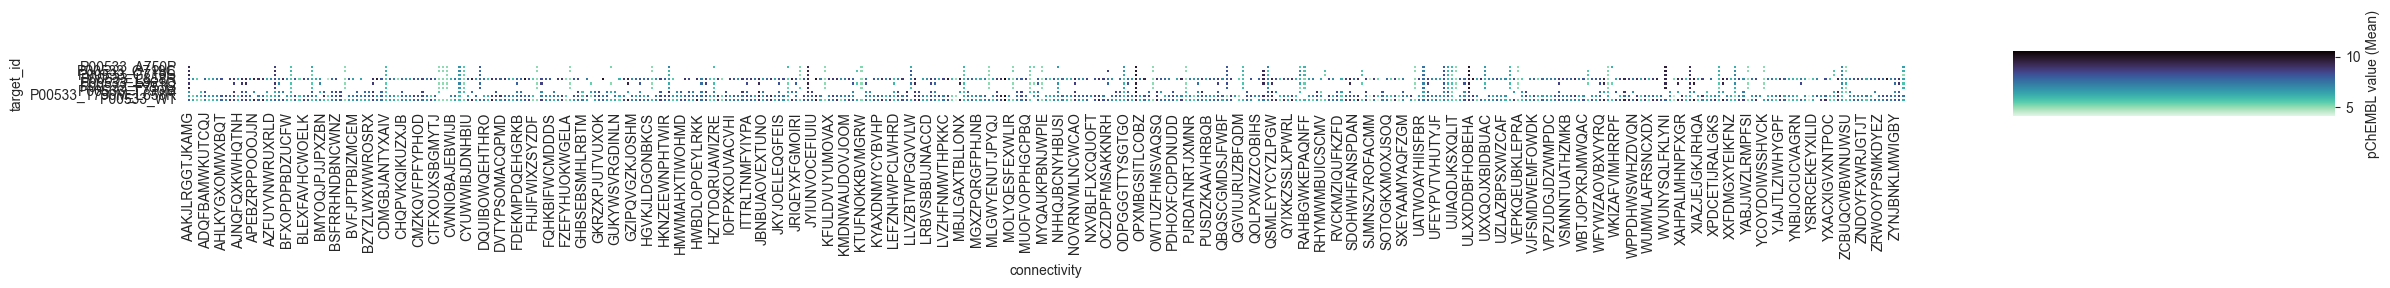

In [16]:
plot_bioactivity_heatmap(analysis_accession, common_subset_df, bioactivity_analysis_dir)

#### Plot strictly common subset clustermap

ValueError: could not convert string to float: 'P00533_A750P'

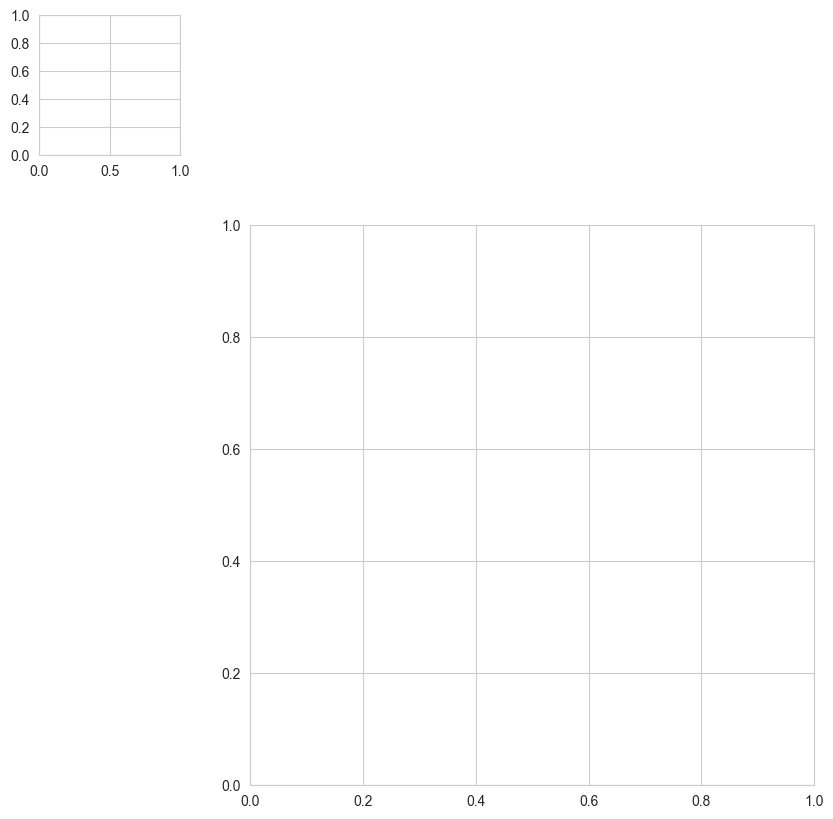

In [17]:
plot_bioactivity_clustermap(analysis_accession, strictly_common_subset_df, None, None, bioactivity_analysis_dir)

#### Plot strictly common subset clustermap with different annotations

##### Compound testing year (in this accession)

In [ ]:
year_dict = extract_oldest_year(accession_data, analysis_accession, strictly_common_subset_list)

In [ ]:
plot_bioactivity_clustermap(analysis_accession, strictly_common_subset_df, 'year', None, bioactivity_analysis_dir,
                            **{'connectivity_year_dict':year_dict})

##### Butina clustering of compounds

In [ ]:
# Define custom substructures to highlight in molecular representations
# (Default is biggest ring system for the whole common subset and maximum common substructure within a cluster for
# each Butina cluster)
substructure_match_dict = {'P00533':{'SMILES':'CNc1ncnc2ccccc12',
                                     'SMARTS':'a1aaaaa1'},
                           'P00519':{'SMILES':'COc1ncnc2ccccc12',
                                     'SMARTS':'a1aaaaa1Na1aaaaa1'},
                           'P36888':{},
                           'Q72547':{}
                           }

In [ ]:
# Plot strictly common subset, highlighting the biggest ring in each molecule for easier comparison
visualize_molecular_subset_highlights(analysis_accession, accession_data, strictly_common_subset_list,
                                      'strictly_common_subset', 'ring',
                                      {}, True, os.path.join(bioactivity_analysis_dir, analysis_accession))

In [ ]:
visualize_molecular_subset_highlights(analysis_accession, accession_data, strictly_common_subset_list,
                                      'strictly_common_subset', 'Murcko',
                                      {}, True, os.path.join(bioactivity_analysis_dir, analysis_accession))


In [ ]:
# Cluster compounds with Butina algorithm
clusters,compounds,connectivity_cluster_dict = butina_cluster_compounds(analysis_accession, accession_data,
                                                                        strictly_common_subset_list,
                                                                        'strictly_common_subset', os.path.join
                                                                        (bioactivity_analysis_dir,
                                                                         analysis_accession), butina_cutoff[analysis_accession])

In [ ]:
# Visualize molecules in first cluster
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0]],
    legends=[compounds[i][1] for i in clusters[0]],
    molsPerRow=5,
)

In [ ]:
# If needed, read output of clusters
# with open(os.path.join(bioactivity_analysis_dir,analysis_accession,f'{analysis_accession}_strictly_common_subset_ButinaClusters_{butina_cutoff[analysis_accession]}'
#                                                    f'.json'))  as \
#         json_file:
#     connectivity_cluster_dict = json.load(json_file)
# connectivity_cluster_dict

In [ ]:
plot_bioactivity_clustermap(analysis_accession, strictly_common_subset_df, 'butina_clusters', None, bioactivity_analysis_dir,
                            **{'connectivity_cluster_dict':connectivity_cluster_dict, 'butina_cutoff':butina_cutoff[analysis_accession]})

##### Distance of mutated residue to ligand COG

In [ ]:
plot_bioactivity_clustermap(analysis_accession, strictly_common_subset_df, None, 'ligand_distance', bioactivity_analysis_dir,
                            **{'dist_dir':distance_dir})

##### Type of amino acid change (quantified by Epstein coefficient, that measures how different wt aa is to mut aa)

In [ ]:
epstein_dict = read_mutation_distance_Epstein()

In [ ]:
plot_bioactivity_clustermap(analysis_accession, strictly_common_subset_df, None, 'aa_change_epstein', bioactivity_analysis_dir,
                            **{'epstein_dict':epstein_dict})